In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [4]:
data = pd.read_excel('CPALTT01USM661S.xlsx', sheet_name='Monthly')
data.rename(columns={'CPALTT01USM661S': 'Index'}, inplace=True)
data.set_index('observation_date', inplace=True)
data.head(4)

,Index
observation_date,
1980-01-01,32.90903
1980-02-01,33.33094
1980-03-01,33.79504
1980-04-01,34.13257


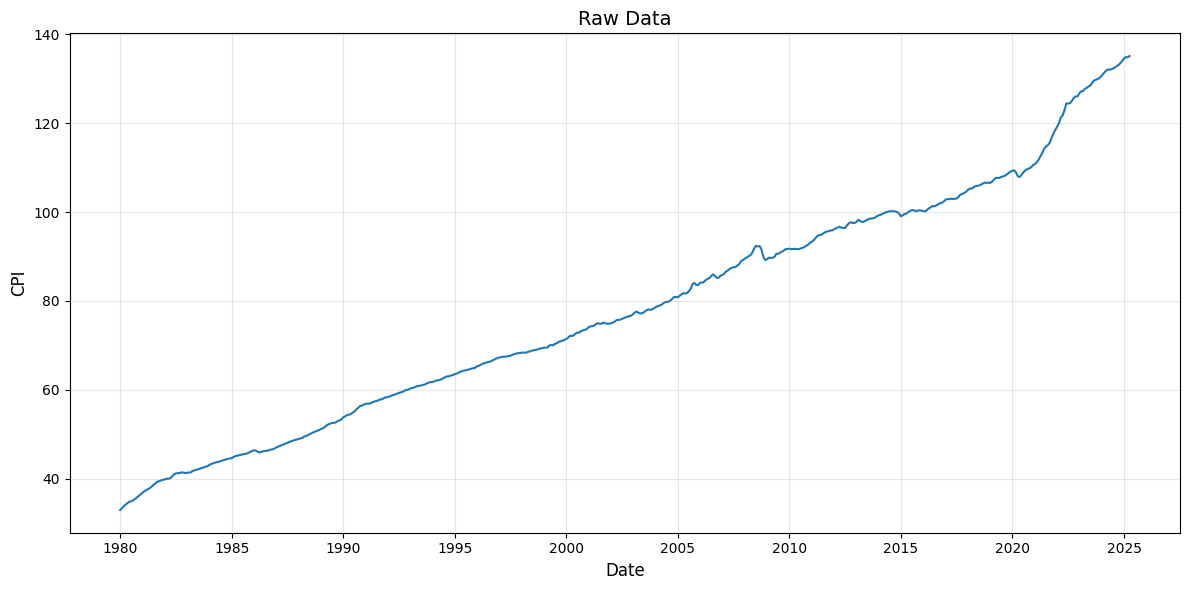

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data["Index"])
plt.title("Raw Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("CPI", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

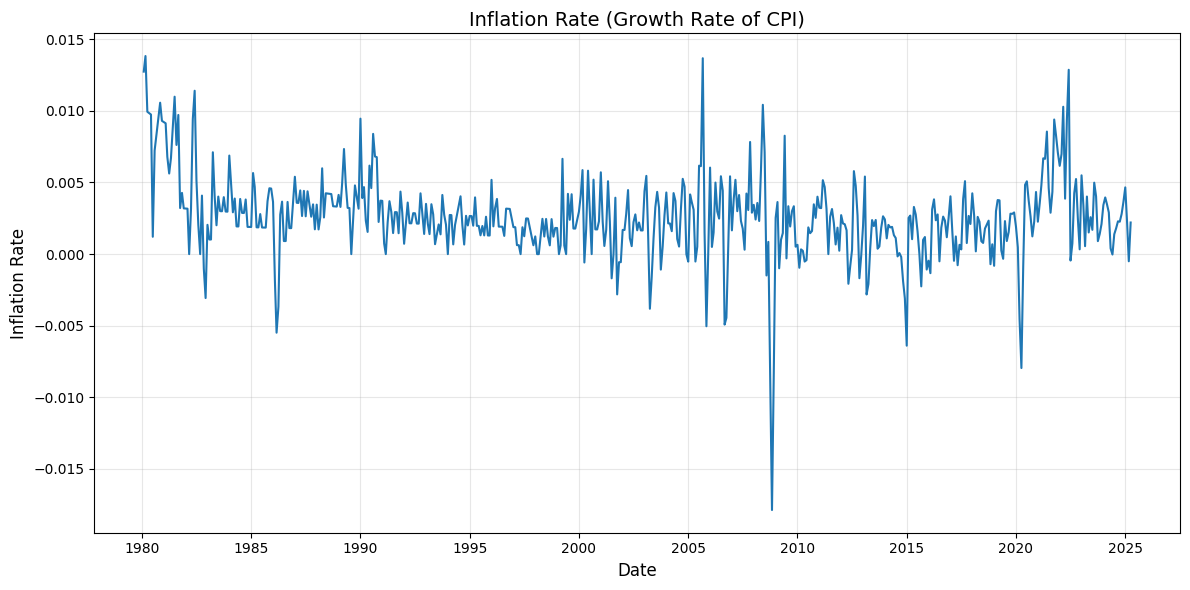

In [8]:
# g_t = ln(CPI_t) - ln(CPI_{t-1})

log_cpi = np.log(data["Index"])
inflation = log_cpi.diff()
data["Log_CPI"] = log_cpi
data["Inflation"] = inflation

plt.figure(figsize=(12, 6))
plt.plot(data["Inflation"])
plt.title("Inflation Rate (Growth Rate of CPI)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inflation Rate", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
n_test = 24

train_df = data.iloc[:-n_test].copy()
test_df = data.iloc[-n_test:].copy()

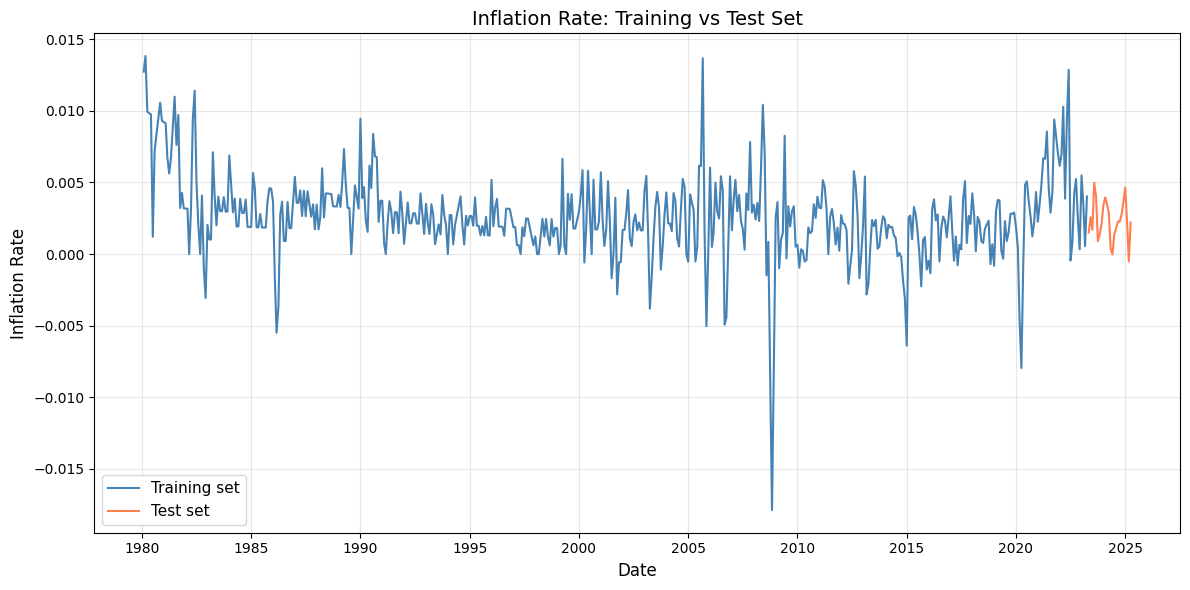

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(train_df["Inflation"], color="steelblue", label="Training set")
plt.plot(test_df["Inflation"], color="coral", label="Test set")
plt.title("Inflation Rate: Training vs Test Set", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inflation Rate", fontsize=12)
plt.legend(loc="best", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Training inflation (drop first NaN from diff() so ARIMA has valid sample)
y_train = train_df["Inflation"].dropna()

# Fit ARIMA(12, 0, 1) on training data only (same as in q7)
model = ARIMA(y_train, order=(12, 0, 1))
fitted_model = model.fit()

# E_hat(Y_{T+k} | F_T) for k = 1, ..., 24
n_forecast = 24
forecast_result = fitted_model.get_forecast(steps=n_forecast)

# Point forecasts (predicted mean)
forecasts = forecast_result.predicted_mean   # series with date index T+1, ..., T+24

# Optional: prediction intervals
# forecast_ci = forecast_result.conf_int(alpha=0.05)

/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/olegglotov/Documents/CHICAGO code/Winter/FINM - Time Series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

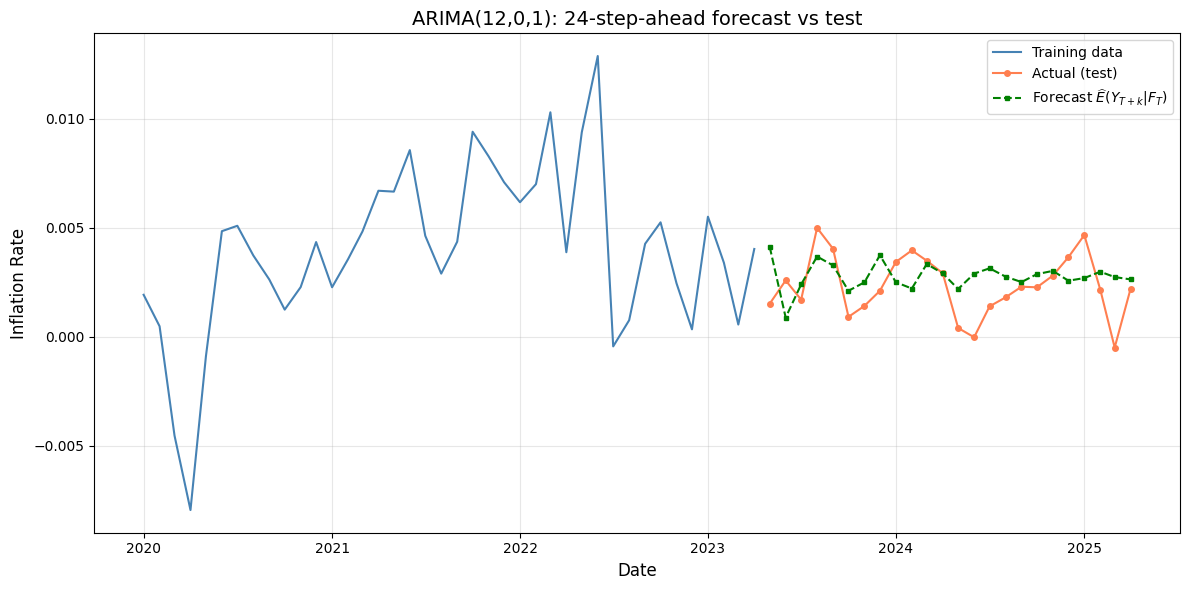

In [16]:
# Actual test values (same dates as forecasts)
y_test = test_df["Inflation"]

# Align: forecasts have index = last training date + 1, ..., + 24
# So forecasts.index should match test_df.index if train/test split is contiguous
forecasts_aligned = forecasts.reindex(y_test.index)   # in case of any index mismatch

# Limit data to last 40 points (for plot clarity)
last_n = 40
train_plot = train_df["Inflation"].iloc[-last_n:]
y_test_plot = y_test.iloc[-last_n:]
forecasts_plot = forecasts_aligned.iloc[-last_n:]

# Plot: training data, then forecast vs actual test
plt.figure(figsize=(12, 6))
plt.plot(train_plot, color="steelblue", label="Training data")
plt.plot(y_test_plot.index, y_test_plot.values, color="coral", marker="o", markersize=4, label="Actual (test)")
plt.plot(forecasts_plot.index, forecasts_plot.values, color="green", linestyle="--", marker="s", markersize=3, label=r"Forecast $\widehat{E}(Y_{T+k}|F_T)$")
plt.title("ARIMA(12,0,1): 24-step-ahead forecast vs test", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inflation Rate", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()